In [1]:
from __future__ import print_function
import os
from skimage import io
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from eval_matrics import evaluate, plot_roc
from torch.autograd import Function
from torch.optim import lr_scheduler
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms, models
import torchvision.datasets as datasets

In [2]:
verbosity      = 0
num_of_classes = 14951
embedding_size = 256
learning_rate  = 0.0002
margin         = 0.5
batch_size     = 20
num_epochs     = 1

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img  = std * img + mean
    img  = np.clip(img, 0, 1)
    plt.axis("off")
    plt.imshow(img)

In [5]:
class PairwiseDistance(Function):
    def __init__(self, p):
        super(PairwiseDistance, self).__init__()
        self.norm = p

    def forward(self, x1, x2):
        assert x1.size() == x2.size()
        eps = 1e-4 / x1.size(1)
        diff = torch.abs(x1 - x2)
        out = torch.pow(diff, self.norm).sum(dim=1)
        return torch.pow(out + eps, 1. / self.norm)

In [6]:
class TripletMarginLoss(Function):
    """Triplet loss function.
    """
    def __init__(self, margin):
        super(TripletMarginLoss, self).__init__()
        self.margin = margin
        self.pdist = PairwiseDistance(2)  # norm 2

    def forward(self, anchor, positive, negative):
        d_p = self.pdist.forward(anchor, positive)
        d_n = self.pdist.forward(anchor, negative)

        dist_hinge = torch.clamp(self.margin + d_p - d_n, min=0.0)
        loss = torch.mean(dist_hinge)
        return loss

In [7]:
class TripletLandmarkDataset(Dataset):

    def __init__(self, root_dir, csv_name, num_of_triplets, transform = None):
        
        self.root_dir          = root_dir
        self.df                = pd.read_csv(csv_name)
        self.num_of_triplets   = num_of_triplets
        self.transform         = transform
        self.training_triplets = self.generate_triplets(self.df, self.num_of_triplets)
        
    @staticmethod
    def generate_triplets(df, num_of_triplets):
        
        def create_landmarks(df):
            # label is 'int', not 'str'. cast it.
            landmarks = dict()
            for idx, label in enumerate(df['landmark_id']):
                if str(label) not in landmarks:
                    landmarks[str(label)] = []
                landmarks[str(label)].append(df.iloc[idx, 0])
            return landmarks

        triplets = []
        classes = df['landmark_id'].unique()
        landmarks = create_landmarks(df) # = {'label0': [id, ...], 'label1': [id, ...], ...}
        
        for idummy in range(num_of_triplets):
            
            '''
              - randomly choose anchor, positive and negative images for triplet loss
              - klabel_p for anchor and positive images
              - klabel_n for negative image
              - at least, two images needed for anchor and positive images in klabel_p
              - negative image should have different label as anchor and positive images by definition
            '''
        
            klabel_p = str(np.random.choice(classes))
            klabel_n = str(np.random.choice(classes))
            while len(landmarks[klabel_p]) < 2:
                klabel_p = str(np.random.choice(classes))
            while klabel_p == klabel_n:
                klabel_n = str(np.random.choice(classes))
            
            if len(landmarks[klabel_p]) == 2:
                ianc, ipos = np.random.choice(2, size = 2, replace = False)
            else:
                ianc = np.random.randint(0, len(landmarks[klabel_p]))
                ipos = np.random.randint(0, len(landmarks[klabel_p]))
                while ianc == ipos:
                    ipos = np.random.randint(0, len(landmarks[klabel_p]))
            ineg = np.random.randint(0, len(landmarks[klabel_n]))
            
            triplets.append([landmarks[klabel_p][ianc], landmarks[klabel_p][ipos], landmarks[klabel_n][ineg], klabel_p, klabel_n])
        
        return triplets
        
        
    def __getitem__(self, idx):
        
        id_a, id_p, id_n, label_p, label_n = self.training_triplets[idx]
        
        # we are trying to train and valdate our algorithms using 'train' set from Kaggle
        # so that use 'train' here.
        img_a = os.path.join(self.root_dir, 'train', str(label_p), str(id_a) + '.jpg')
        img_p = os.path.join(self.root_dir, 'train', str(label_p), str(id_p) + '.jpg')
        img_n = os.path.join(self.root_dir, 'train', str(label_n), str(id_n) + '.jpg')
        
        img_a = io.imread(img_a)
        img_p = io.imread(img_p)
        img_n = io.imread(img_n)

        label_p    = torch.from_numpy(np.array([label_p]).astype('long'))
        label_n    = torch.from_numpy(np.array([label_n]).astype('long'))
        
        sample = {'img_a': img_a, 'img_p': img_p, 'img_n': img_n, 'label_p': label_p, 'label_n': label_n}

        if self.transform:
            sample['img_a'] = self.transform(sample['img_a'])
            sample['img_p'] = self.transform(sample['img_p'])
            sample['img_n'] = self.transform(sample['img_n'])
        
        
        #print(sample['label_p'])
        
        return sample
    
    
    def __len__(self):
        
        return len(self.training_triplets)

In [8]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomResizedCrop(96),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(98),
        transforms.CenterCrop(96),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
    ])
}

landmarks_dataset = {
    'train' : TripletLandmarkDataset(root_dir        = '/mnt/sw/workspace/Google',
                                     csv_name        = './top5_landmarks_shrunk_train0.csv',
                                     num_of_triplets = 10000,
                                     transform       = data_transforms['train']),
    'val'   : TripletLandmarkDataset(root_dir        = '/mnt/sw/workspace/Google',
                                     csv_name        = './top5_landmarks_shrunk_val0.csv',
                                     num_of_triplets = 2000,
                                     transform       = data_transforms['val'])
}

[[9633]]
[[9779]]


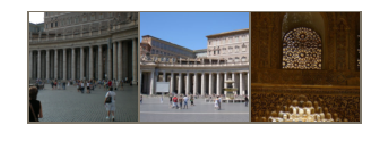

In [9]:
# comparision plots using a batch of training set

dataloaders = {
    x: torch.utils.data.DataLoader(landmarks_dataset[x], batch_size = 1, shuffle = False, num_workers = 0)
    for x in ['train', 'val']
}

example_batch = next(iter(dataloaders['train']))

concatenated = torch.cat((example_batch['img_a'], example_batch['img_p'], example_batch['img_n']), 0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch['label_p'].numpy())
print(example_batch['label_n'].numpy())

In [10]:
# Data augmentation and normalization for training
# Just normalization for validation

dataloaders = {
    x: torch.utils.data.DataLoader(landmarks_dataset[x], batch_size = batch_size, shuffle = False, num_workers = 8)
    for x in ['train', 'val']
}

dataset_sizes = { x: len(landmarks_dataset[x]) for x in ['train', 'val'] }

print(dataset_sizes['train'])
print(dataset_sizes['val'])

10000
2000


In [11]:
l2_dist = PairwiseDistance(2)

In [12]:
class TripletLandmarkModel(nn.Module):
    def __init__(self, embedding_size, num_of_classes, pretrained = False):
        super(TripletLandmarkModel, self).__init__()
        
        self.model            = models.resnet18(pretrained)
        self.embedding_size   = embedding_size
        self.model.fc         = nn.Linear(512*3*3, self.embedding_size)
        self.model.classifier = nn.Linear(self.embedding_size, num_of_classes)
        
    
    def l2_norm(self, x):
        
        input_size = x.size()
        buffer = torch.pow(x, 2)
        
        normp = torch.sum(buffer, 1).add_(1e-10)
        norm = torch.sqrt(normp)
        
        _y = torch.div(x, norm.view(-1, 1).expand_as(x))
        y = _y.view(input_size)
        
        return y
        
        
    def forward(self, x):
        
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = x.view(x.size(0), -1)

        x = self.model.fc(x)
        self.features = self.l2_norm(x)
        # multiply by alpha = 10 as suggested in https://arxiv.org/pdf/1703.09507.pdf
        alpha = 10
        self.features = self.features*alpha
        
        #x = self.model.clasifier(self.features)
        return self.features
        

    def forward_classifier(self, x):
        features = self.forward(x)
        res = self.model.classifier(features)
       
        return res        

In [31]:
def train_validate_model(model, optimizer, scheduler, num_epochs):
    
    for epoch in range(num_epochs):
        
        print('=' * 50)
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        
        labels    = {'train': [], 'val': []}
        distances = {'train': [], 'val': []}
        
        for phase in ['train']:

            running_loss = 0.0
            
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()
                                            
            for idx_batch, sampled_batch in enumerate(dataloaders[phase]):
                
                if idx_batch == 1:
                    break
                    
                img_a   = sampled_batch['img_a'].to(device)
                img_p   = sampled_batch['img_p'].to(device)
                img_n   = sampled_batch['img_n'].to(device)
                label_p = sampled_batch['label_p'].to(device)
                label_n = sampled_batch['label_n'].to(device)
            
                print(img_p.shape)
            
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    # compute output
                    # out_a, out_p and out_n are encoding(embedding) of image
                    out_a, out_p, out_n = model(img_a), model(img_p), model(img_n)
                
                    # choose the hard negatives only for "training"
                    d_p = l2_dist.forward(out_a, out_p)
                    d_n = l2_dist.forward(out_a, out_n) 
                    
                    all = (d_n - d_p < margin).cpu().numpy().flatten()
                    if phase == 'train':
                        hard_triplets = np.where(all == 1)
                        if len(hard_triplets[0]) == 0:
                            continue
                    else:
                        hard_triplets = np.where(all >= 0)
                        
                    selected_out_a   = out_a[hard_triplets].to(device)
                    selected_out_p   = out_p[hard_triplets].to(device)
                    selected_out_n   = out_n[hard_triplets].to(device)
                    
                    selected_img_a   = img_a[hard_triplets].to(device)
                    selected_img_p   = img_p[hard_triplets].to(device)
                    selected_img_n   = img_n[hard_triplets].to(device)

                    selected_label_p = label_p[hard_triplets]
                    selected_label_n = label_n[hard_triplets]

                    triplet_loss     = TripletMarginLoss(margin).forward(selected_out_a, selected_out_p, selected_out_n).to(device)

                    cls_a = model.forward_classifier(selected_img_a)
                    cls_p = model.forward_classifier(selected_img_p)
                    cls_n = model.forward_classifier(selected_img_n)
                  
                    criterion        = nn.CrossEntropyLoss()
                    predicted_labels = torch.cat([cls_a.to(device), cls_p.to(device), cls_n.to(device)])
                    true_labels      = torch.cat([selected_label_p.to(device), selected_label_p.to(device), selected_label_n.to(device)])
                    true_labels      = true_labels[:,0]
                                      
                    cross_entropy_loss = criterion(predicted_labels.to(device), true_labels.to(device))

                    loss = cross_entropy_loss + triplet_loss

                    # compute gradient and update weights
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                    
                        dists = l2_dist.forward(out_a, out_n)
                        distances[phase].append(dists.data.cpu().numpy())
                        labels[phase].append(np.zeros(dists.size(0)))

                       
                    dists = l2_dist.forward(out_a, out_p)  
                    distances[phase].append(dists.data.cpu().numpy())
                    labels[phase].append(np.ones(dists.size(0)))
                        
                    running_loss += loss.item()
                    
            epoch_loss = running_loss / dataset_sizes[phase]
               
            labels[phase]    = np.array([sublabel for label in labels[phase] for sublabel in label])
            distances[phase] = np.array([subdist for dist in distances[phase] for subdist in dist])

            tpr, fpr, accuracy = evaluate(distances[phase], labels[phase])

            if phase == 'train':
                print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            print('\33[91m{} Accuracy: {:.8f}\33[0m'.format(phase, np.mean(accuracy)))
                
            plot_roc(fpr, tpr, figure_name = "ROC_{}_Epoch_{}.png".format(phase, epoch))

            # do checkpointing
            torch.save({'epoch': epoch + 1, 'state_dict': model.state_dict()},
                        '{}/checkpoint_{}.pth'.format('./log', epoch))
            #torch.save(model, '{}/checkpoint_{}.pth'.format('./log', epoch))
            
            
        if epoch == num_epochs - 1:
            print('=' * 50)
        
            
    return model

In [32]:
model     = TripletLandmarkModel(embedding_size = embedding_size, num_of_classes = num_of_classes, pretrained = True)
model     = model.to(device)

# observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.1)

Epoch 1/1
torch.Size([20, 3, 96, 96])
train Loss: 0.0002
train Accuracy: 0.92500000


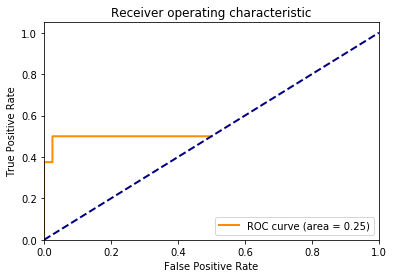

In [33]:
start_epoch = 3
checkpoint = torch.load('{}/checkpoint_{}.pth'.format('./log', start_epoch))
model.load_state_dict(checkpoint['state_dict'])

model = train_validate_model(model, optimizer, exp_lr_scheduler, num_epochs = num_epochs)